In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
# Load the CSV file
data = pd.read_csv('/Users/saieshagre/Downloads/Package Standardization/altered_data.csv')
# data = data.drop_duplicates(subset=['Height', 'Width', 'Depth'], keep='first')
# data.sort_values(by = ['Height', 'Width', 'Depth'], inplace = True)
data.reset_index()

,index,Model,Depth,Width,Height
0,0,RISH Xmer 62/W,40,62,78.0
1,1,RISH Xmer 74/W,45,74,98.0
2,2,RISH Xmer 45/14(40),40,45,65.0
3,3,RISH Xmer 45/14(40),40,45,65.0
4,4,RISH Xmer 50/14(30),32,51,70.0
...,...,...,...,...,...
73,73,LTRC-6 195/130(40),40,195,219.0
74,74,LTRC-7 230/165(40),40,230,255.0
75,75,LTRC-8 295/200(40),40,295,320.0
76,76,Sigma 75,70,75,113.0


In [5]:
dimensions = data[['Depth', 'Width', 'Height']]
scaler = StandardScaler()
scaled_dim = scaler.fit_transform(dimensions)

In [6]:
# Elbow method to find the optimal number of clusters
inertia = []
k_range = range(1, 30)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_dim)
    inertia.append(kmeans.inertia_)

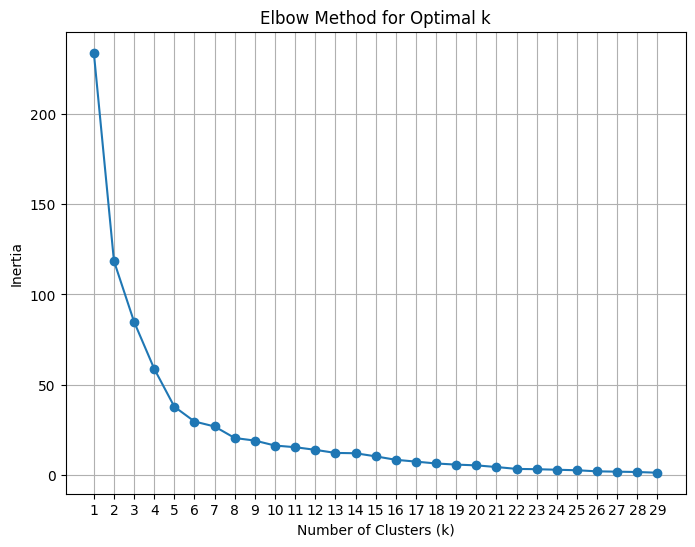

In [7]:
# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [8]:
# User-defined number of clusters
num_clusters = int(input("Enter the number of clusters: "))

Enter the number of clusters:  23


In [9]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters = num_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_dim)

In [10]:
# Organize the output
clustered_df = data[['Model', 'Depth', 'Width', 'Height', 'Cluster']]

In [11]:
# Calculate the maximum dimension for each cluster
max_dims = clustered_df.groupby('Cluster').agg({
    'Depth': 'max',
    'Width': 'max',
    'Height': 'max'
}).rename(columns={
    'Depth': 'Max_Depth',
    'Width': 'Max_Width',
    'Height': 'Max_Height'
})

In [12]:
clustered_df = clustered_df.merge(max_dims, on='Cluster')
clustered_df.sort_values(by = ['Cluster'], inplace = True)

In [13]:
clustered_df['Volume_Difference_Percentage'] = (
    ((clustered_df['Max_Depth'] * clustered_df['Max_Width'] * clustered_df['Max_Height'] - clustered_df['Depth'] * clustered_df['Width'] * clustered_df['Height']) / 
     (clustered_df['Max_Depth'] * clustered_df['Max_Width'] * clustered_df['Max_Height'])) * 100
).round(2)

In [14]:
# Step 4: Calculate the average percentage difference per cluster
average_percent_diff_per_cluster = clustered_df.groupby('Cluster')['Volume_Difference_Percentage'].mean().round(2).reset_index()

# Rename column for clarity
average_percent_diff_per_cluster.columns = ['Cluster', 'Average_Volume_Diff_Percentage']

# Step 5: Merge the average percentage difference back into the original DataFrame
clustered_df = clustered_df.merge(average_percent_diff_per_cluster, on='Cluster', how='left')

In [15]:
average_diff_across_cluster = clustered_df['Average_Volume_Diff_Percentage'].unique().sum() / num_clusters
average_diff_across_cluster

8.370869565217392

In [16]:
rows = []
for cluster, group in clustered_df.groupby('Cluster'):
    rows.append(group)  # Add the rows for the current cluster
    rows.append(pd.DataFrame([[''] * len(clustered_df.columns)], columns=clustered_df.columns))  # Add a blank row

# Concatenate all rows into a new DataFrame
clustered_df = pd.concat(rows, ignore_index=True)

In [17]:
clustered_df.to_csv('/Users/saieshagre/Downloads/Package Standardization/clustered.csv')